Obtaining the signatures for a petition on Change.org

Sergia, 2021 sergia94@protonmail.com for Worldie

## Intro

Change.org is a platform offering petitions that can be signed and commented on.

The overall task is to search for a petitions on a topic, and collect signatures (with timestamps and names) and comments (with timestamps and names). An additional task is to obtain the creation dates for accounts.

The platform has discontinued its official API without any replacement: https://help.change.org/s/article/Change-org-API?language=en_US which makes the problem not straightforward. This means that the previous repositories on GitHub such as https://github.com/edsadr/change-api do not work anymore either...

In this notebook we reverse-engineer the API that the Change.org website uses to obtain the information, and solve a part of the defined problem: obtaining the signatures for a given petition

We use this petition as an example: https://www.change.org/p/hollywood-boycott-aquaman-2-amber-heard (found via search on Change.org)

### Reverse-engineering the API

The process is fairly straightforward.

Modern websites usually use a static JavaScript code for the page, which issues requests to the API server to fill in the information (such as content, comments, ...). The general rule is that everything that can be seen on the page (and usually more) is accessible via that API programmatically -- Change.org is not an exception. Some websites use complicated defenses against such non-standard uses of their services, in that case an alternative is to use a script-controlled browser window such as <a href="https://selenium-python.readthedocs.io/" target="_blank">Selenium</a>. In that case, the website server would literally have no way to tell if a request is coming from a real person, or from a script.

We are looking for signatures, and the interface shows that one of them is "Madelyn Ullsperger". The web page is likely issuing a request and obtaining a JSON response. We look for all JSON responses (column "type" in the Developer Tools/Network window) and search for those that contain "Madelyn". We find it (highlighted line on the screenshot below) as a POST query to the GraphQL server of Change.org. We see the name "Madelyn" on the right-hand side, as well as the timing when the signature was made. It seems that Change.org uses <a href="https://graphql.org/" target="_blank">GraphQL</a> API internally for their website, which could simplify our work significantly in the future, as we can issue non-standard requests as well. For now, all we want are the signatures, so we will not use a GraphQL clients and will just issue the "hand-coded" requests:

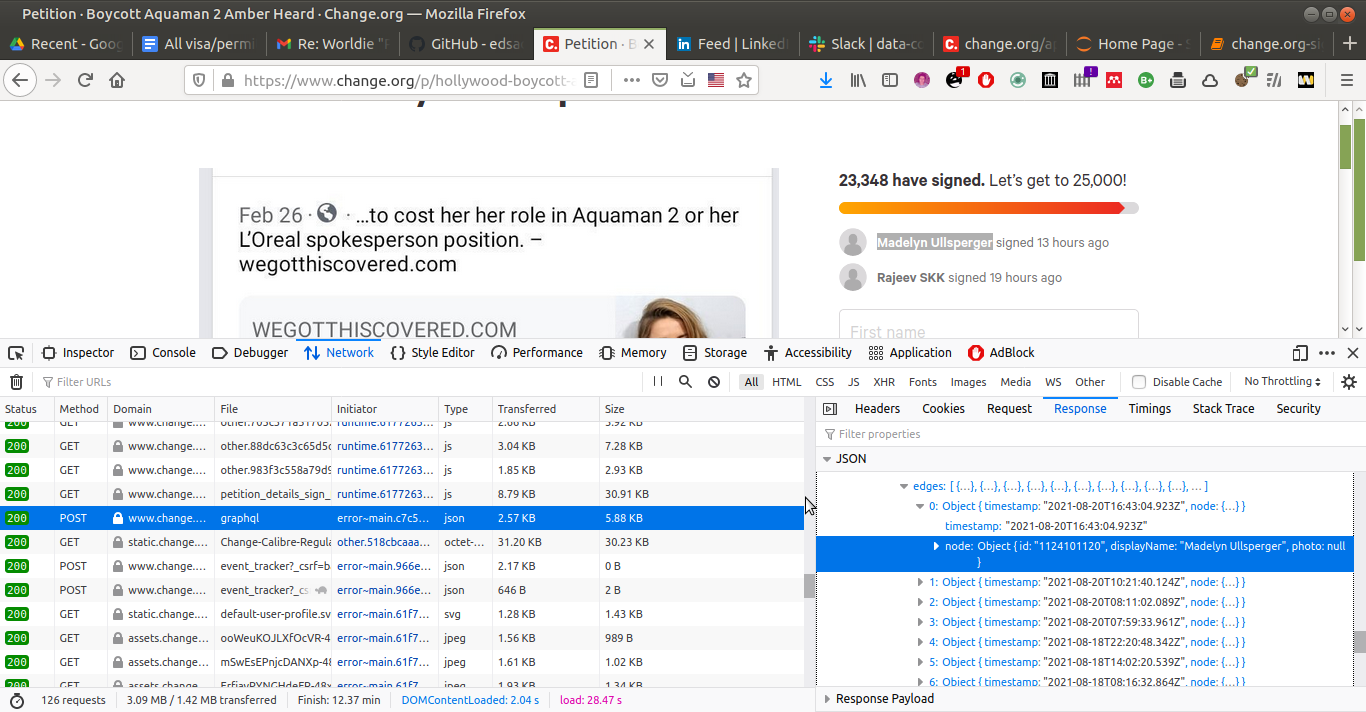

We copy the URL of the request (right-click on the blue line on the left) and obtain

<b>https://www.change.org/api-proxy/graphql</b>

We verify that the requests to this URL work by running the cURL command (right click, Copy, Copy as cURL, and run it in the command line:

```
curl 'https://www.change.org/api-proxy/graphql' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:85.0) Gecko/20100101 Firefox/85.0' -H 'Accept: application/json' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://www.change.org/p/hollywood-boycott-aquaman-2-amber-heard' -H 'content-type: application/json' -H 'X-Requested-With: http-link' -H 'Origin: https://www.change.org' -H 'Connection: keep-alive' -H 'Cookie: ***' -H 'Sec-GPC: 1' -H 'Pragma: no-cache' -H 'Cache-Control: no-cache' -H 'TE: Trailers' --data-raw  ***
```

It does work!

We see that the request is of POST type, and we obtain the data using the same right-click menu, and copy it inside a Python cell:

In [118]:
# string below copied from Developer Tools
petition_signatures_graphql_post_request = \
\
"[{\"operationName\":null,\"variables\":{\"locale\":\"en-US\",\"countryCode\":\"CH\"},\"query\":\"query ($locale: String!, $countryCode: String!) {\\n  featureConfigs {\\n    gdpr_cookie_prefs: featureConfig(\\n      name: \\\"gdpr_cookie_prefs\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n  }\\n}\\n\"},{\"operationName\":null,\"variables\":{\"locale\":\"en-US\",\"countryCode\":\"CH\"},\"query\":\"query ($locale: String!, $countryCode: String!) {\\n  featureConfigs {\\n    maintenance_banner: featureConfig(\\n      name: \\\"maintenance_banner\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n  }\\n}\\n\"},{\"operationName\":null,\"variables\":{\"locale\":\"en-US\",\"countryCode\":\"CH\"},\"query\":\"query ($locale: String!, $countryCode: String!) {\\n  featureConfigs {\\n    show_csat_survey_banner: featureConfig(\\n      name: \\\"show_csat_survey_banner\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n    show_csat_survey_banner_sampling: featureConfig(\\n      name: \\\"show_csat_survey_banner_sampling\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n  }\\n}\\n\"},{\"operationName\":null,\"variables\":{\"locale\":\"en-US\",\"countryCode\":\"CH\"},\"query\":\"query ($locale: String!, $countryCode: String!) {\\n  featureConfigs {\\n    gdpr_consent_optin_banner: featureConfig(\\n      name: \\\"gdpr_consent_optin_banner\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n    gdpr_consent_optin_banner_copy: featureConfig(\\n      name: \\\"gdpr_consent_optin_banner_copy\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n  }\\n}\\n\"},{\"operationName\":null,\"variables\":{\"locale\":\"en-US\",\"countryCode\":\"CH\"},\"query\":\"query ($locale: String!, $countryCode: String!) {\\n  featureConfigs {\\n    supporter_petition_tabs_update_count: featureConfig(\\n      name: \\\"supporter_petition_tabs_update_count\\\"\\n      groups: [$locale, $countryCode]\\n    )\\n  }\\n}\\n\"},{\"operationName\":null,\"variables\":{},\"query\":\"{\\n  session: viewer {\\n    consentResponses {\\n      globalConsentInitialEu\\n    }\\n  }\\n}\\n\"},{\"operationName\":\"PetitionStats\",\"variables\":{\"petitionSlug\":\"hollywood-boycott-aquaman-2-amber-heard\",\"maxSigners\":20,\"shouldFetchRecruiter\":false,\"recruiterId\":\"\"},\"query\":\"query PetitionStats($petitionSlug: String!, $maxSigners: Int!, $shouldFetchRecruiter: Boolean!, $recruiterId: ID!) {\\n  petitionStats: petitionBySlug(slug: $petitionSlug) {\\n    id\\n    signatureCount {\\n      displayed\\n    }\\n    signatureGoal {\\n      displayed\\n    }\\n    recentSignersConnection(first: $maxSigners) {\\n      edges {\\n        timestamp\\n        node {\\n          id\\n          displayName\\n          photo {\\n            id\\n            userSmall {\\n              url\\n            }\\n          }\\n        }\\n      }\\n    }\\n  }\\n  recruiter: userById(id: $recruiterId) @include(if: $shouldFetchRecruiter) {\\n    id\\n    displayName\\n    photo {\\n      id\\n      userSmall {\\n        url\\n      }\\n    }\\n  }\\n}\\n\"}]"

Let's print the request in a nice form:

In [119]:
print(petition_signatures_graphql_post_request.strip())

[{"operationName":null,"variables":{"locale":"en-US","countryCode":"CH"},"query":"query ($locale: String!, $countryCode: String!) {\n  featureConfigs {\n    gdpr_cookie_prefs: featureConfig(\n      name: \"gdpr_cookie_prefs\"\n      groups: [$locale, $countryCode]\n    )\n  }\n}\n"},{"operationName":null,"variables":{"locale":"en-US","countryCode":"CH"},"query":"query ($locale: String!, $countryCode: String!) {\n  featureConfigs {\n    maintenance_banner: featureConfig(\n      name: \"maintenance_banner\"\n      groups: [$locale, $countryCode]\n    )\n  }\n}\n"},{"operationName":null,"variables":{"locale":"en-US","countryCode":"CH"},"query":"query ($locale: String!, $countryCode: String!) {\n  featureConfigs {\n    show_csat_survey_banner: featureConfig(\n      name: \"show_csat_survey_banner\"\n      groups: [$locale, $countryCode]\n    )\n    show_csat_survey_banner_sampling: featureConfig(\n      name: \"show_csat_survey_banner_sampling\"\n      groups: [$locale, $countryCode]\n    

We see that the request is fairly generic (not specific to the petition), with two placeholder values (for now):

* `petitionSlug` (=`hollywood-boycott-aquaman-2-amber-heard`)
* `maxSigners` (=`20`)

We replace the placeholders with a string formatting query in Python:

In [120]:
petition_signatures_graphql_post_request_template = \
    petition_signatures_graphql_post_request.\
    replace('"petitionSlug":"hollywood-boycott-aquaman-2-amber-heard"', '"petitionSlug":"%s"').\
    replace('"maxSigners":20', '"maxSigners":%d')

We create a function returning the POST request body for a given petition and a requested number of signatures:

In [121]:
def petition_signatures_request(petitionSlug, maxSigners):
    """Obtain the request to obtain the requested number of signatures for a given petition (by slug)."""
    return petition_signatures_graphql_post_request_template % (petitionSlug, maxSigners)

Let's try to run this request:

In [122]:
import requests

# see above how we got it
url = 'https://www.change.org/api-proxy/graphql'

# from search on Change.org
petition_slug = "hollywood-boycott-aquaman-2-amber-heard"

# they use 20, we'll get 30
number_signatures = 20

# the POST request
data_str = petition_signatures_request(petitionSlug=petition_slug,
                                       maxSigners=number_signatures).strip()

x = requests.post(url, data=data_str)

In [123]:
x

<Response [403]>

We see an error (403/Forbidden) -- likely because we did not set the right headers. 

We set the headers as in the cURL example above

In [160]:
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:85.0) Gecko/20100101 Firefox/85.0',
    'Accept': 'application/json',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.change.org/p/' + petition_slug,
    'content-type': 'application/json',
    'X-Requested-With': 'http-link',
    'Origin': 'https://www.change.org',
    
    # this we can get via Selenium
    # but actually we don't even need it
#     'Cookie': '_change_session=0ccbdae59ad205509a87d4ccaac10b22; _change_lang=%7B%22locale%22%3A%22en-US%22%2C%22countryCode%22%3A%22CH%22%7D; __cfruid=52df2690810b7adc3fab2488ce9bc11daad0b5d1-1629521373; optimizelyEndUserId=oeu1629521378944r0.34965887355134595; G_ENABLED_IDPS=google',
    
    
    'Sec-GPC': '1',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'TE': 'Trailers'
}

In [167]:
x = requests.post(url, data=data_str, headers=headers)

In [168]:
x

<Response [200]>

#### We got the data!

Now let's pretty-print the signatures

In [163]:
data = x.json()[6]['data']['petitionStats']['recentSignersConnection']['edges']

data[0]

{'timestamp': '2021-08-20T16:43:04.923Z',
 'node': {'id': '1124101120',
  'displayName': 'Madelyn Ullsperger',
  'photo': None}}

In [164]:
import pandas as pd
from collections.abc import MutableMapping

def flatten_dict(d: MutableMapping, parent_key: str = '', sep: str ='.') -> MutableMapping:
    """Flatten a dictionary.
    
    
    Taken from https://www.freecodecamp.org/news/how-to-flatten-a-dictionary-in-python-in-4-different-ways/
    """
    
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [165]:
df = pd.DataFrame(map(flatten_dict, data))

In [166]:
df

,timestamp,node.id,node.displayName,node.photo,node.photo.id,node.photo.userSmall.url
0,2021-08-20T16:43:04.923Z,1124101120,Madelyn Ullsperger,NaN,NaN,NaN
1,2021-08-20T10:21:40.124Z,1222264130,Rajeev SKK,NaN,NaN,NaN
2,2021-08-20T08:11:02.089Z,1222251301,Indupa Umayanga,NaN,NaN,NaN
3,2021-08-20T07:59:33.961Z,269769856,Katy Dunkley,NaN,112287734,//assets.change.org/photos/2/we/uk/ooWeuKOJLXf...
4,2021-08-18T22:20:48.342Z,28101529,Santiago Peck,NaN,196276657,//assets.change.org/photos/2/we/se/mSwEsEPnjcD...
5,2021-08-18T14:02:20.539Z,1221861883,Edd Elk,NaN,NaN,NaN
6,2021-08-18T08:16:32.864Z,1171673134,Yash Rathi,NaN,NaN,NaN
7,2021-08-18T07:28:27.045Z,1207341649,Matthew Middlewick,NaN,NaN,NaN
8,2021-08-18T04:08:17.252Z,1219054687,Jennifer Clark,NaN,NaN,NaN
9,2021-08-18T01:10:10.238Z,1129640182,Alexis Nichols,NaN,NaN,NaN


# Voila!

Now we make our results available via a simple Python script call and try it on another petition:

`python get_last_signatures_csv.py --petition_slug united-states-supreme-court-put-amber-heard-behind-bars --number_signatures 30`

In [171]:
!python get_last_signatures_csv.py --petition_slug united-states-supreme-court-put-amber-heard-behind-bars --number_signatures 30

Response: 200 OK
Data saved to change_org_petition_slug_united-states-supreme-court-put-amber-heard-behind-bars_at_20210821-084803_max_number_signatures_30.csv


In [172]:
!cat change_org_petition_slug_united-states-supreme-court-put-amber-heard-behind-bars_at_20210821-084803_max_number_signatures_30.csv

timestamp,node.id,node.displayName,node.photo.id,node.photo.userSmall.url,node.photo
2021-08-21T04:49:10.683Z,863157274,Amber Rye,219445047,//assets.change.org/photos/8/rg/hp/PXrgHPphSlmqlsw-48x48-noPad.jpg?1521027159,
2021-08-20T11:39:35.670Z,980832060,Roosa Heikkinen,,,
2021-08-16T19:36:05.456Z,1125452083,Lydia Fiebig,,,
2021-08-15T13:25:45.699Z,1221146397,Prasanjit Biswal,,,
2021-08-14T06:28:21.497Z,1220881815,Vinayak Ray,,,
2021-08-13T14:56:52.815Z,47926392,Megan Stallings,11325376,//assets.change.org/photos/3/mo/uc/femoucoVoIkIbXg-48x48-noPad.jpg?1521127686,
2021-08-11T07:46:57.131Z,1204647010,Windra Mosher,,,
2021-08-10T17:47:12.277Z,714813554,Nataniele Casini,,,
2021-08-10T14:17:19.610Z,329935567,Kelly Shirey,225833576,//assets.change.org/photos/7/gp/vq/WxGPVQiGtsbHmhv-48x48-noPad.jpg?1628605310,
2021-08-10T09:18:43.466Z,1219933097,Audra Mosher,,,
2021-08-09T15:23:41.140Z,557990822,Jake Kempa,,,
2021-08-09T02:14:29.247Z,1012243072,Kelli Shofstall,223427574,//assets.change.org/ph

In [176]:
pd.read_csv('change_org_petition_slug_united-states-supreme-court-put-amber-heard-behind-bars_at_20210821-084803_max_number_signatures_30.csv')

,timestamp,node.id,node.displayName,node.photo.id,node.photo.userSmall.url,node.photo
0,2021-08-21T04:49:10.683Z,863157274,Amber Rye,219445047.0,//assets.change.org/photos/8/rg/hp/PXrgHPphSlm...,NaN
1,2021-08-20T11:39:35.670Z,980832060,Roosa Heikkinen,NaN,NaN,NaN
2,2021-08-16T19:36:05.456Z,1125452083,Lydia Fiebig,NaN,NaN,NaN
3,2021-08-15T13:25:45.699Z,1221146397,Prasanjit Biswal,NaN,NaN,NaN
4,2021-08-14T06:28:21.497Z,1220881815,Vinayak Ray,NaN,NaN,NaN
5,2021-08-13T14:56:52.815Z,47926392,Megan Stallings,11325376.0,//assets.change.org/photos/3/mo/uc/femoucoVoIk...,NaN
6,2021-08-11T07:46:57.131Z,1204647010,Windra Mosher,NaN,NaN,NaN
7,2021-08-10T17:47:12.277Z,714813554,Nataniele Casini,NaN,NaN,NaN
8,2021-08-10T14:17:19.610Z,329935567,Kelly Shirey,225833576.0,//assets.change.org/photos/7/gp/vq/WxGPVQiGtsb...,NaN
9,2021-08-10T09:18:43.466Z,1219933097,Audra Mosher,NaN,NaN,NaN


Feel free to try with your own data!